In [1]:
from brian2 import *

from adex_sine import *

defaultclock.dt = 10 * us


class Model:
    # Model type flags
    SINE = 0
    EXP2SYN = 1

    # Noise flags
    HIGH = 0
    LOW = 1
    OFF = -1

    # Noise parameters
    EXCITATORY_NOISE_VARIANCE = {HIGH: 0.5 * nS, LOW: 0.25 * nS, OFF: 0 * nS}
    INHIBITORY_NOISE_VARIANCE = {HIGH: 1.25 * nS, LOW: 0.625 * nS, OFF: 0 * nS}

    # Noise mean conductance
    EXCITATORY_CONDUCTANCE = 1 * nS
    INHIBITORY_CONDUCTANCE = 4 * nS

    DEFAULT_PARAMETERS = {
        "sigma_flux" : 6.75*pA,     
        "c": 85 * pF,
        "tau_w": 18 * ms,
        "b": 0.25 * nA,
        "a": 1.3 * nS,
        "v_T": -45 * mV,
        "v_thresh": 0 * mV,
        "DeltaT": 0.2 * mV,
        # EQUILIBRIUM POTENTIAL
        "e_l": -65 * mV,
        "e_ex": 0 * mV,
        "e_in": -70 * mV,
        # CONDUCTANCES
        "g_l": 3 * nS,
        "mu_ex": 0 * nS,
        "mu_in": 0 * nS,
        # EXCITATORY NOISE
        "sigma_ex": 0 * nS,
        "tau_noise_ex": 3 * ms,
        # INHIBITORY NOISE
        "sigma_in": 0 * nS,
        "tau_noise_in": 10 * ms,
        # SINE INPUT
        "f": 100 * Hz,
        "A": 0 * pA,
        "i_injected": 0 * pA,
        "v_reset": -70 * mV,
        # m current
        "g_adapt": 10 * nS,
        "e_k": -90*mV,
        "beta_z": -35*mV,
        "gamma_z": 4*mV,     #5
        "tau_z": 100*ms,
    }

    def __init__(
        self, n, *, stim=None, noise=None, resistance=None, additional_vars=()
    ):
        if resistance is None:
            raise ValueError("Resistance must be specified")

        if noise is None:
            raise ValueError("Noise must be specified")

        self.stim_type = stim
        self._input_resistance = None
        self._noise_level = None
        self._duration = 0
        self.recorded_vars = ("v",) + additional_vars

        self.neurons = self.set_default(n_neuron=n)
        self.set_resistance(resistance)
        self.set_noise(noise)

        self.spikes = None
        self.spiker = None
        self.synapses = None
        self.inhib_synapses = None
        self.smon = None
        self.network = None
        self.build_network()

    def create_model(self):
        return ADEX_MODEL, self.DEFAULT_PARAMETERS

    def set_default(self, n_neuron):
        model, parameters = self.create_model()

        neurons = NeuronGroup(
            n_neuron,
            model=model,
            method="Euler",
            name="neurons",
            threshold="v > v_thresh",
            reset="v = v_reset; w += b",
        )

        for parameter, value in parameters.items():
            neurons.__setattr__(parameter, value)

        neurons.v = neurons.e_l  # remove most of transient

        return neurons

    def set_resistance(self, level):
        if level == self.LOW:
            exc_conductance = self.EXCITATORY_CONDUCTANCE
            inhib_conductance = self.INHIBITORY_CONDUCTANCE

        else:
            exc_conductance = inhib_conductance = 0

        self._input_resistance = level
        self._set_variable("mu_ex", exc_conductance)
        self._set_variable("mu_in", inhib_conductance)

    def set_noise(self, level):
        if level == self.HIGH or level == self.LOW:
            exc_noise = self.EXCITATORY_NOISE_VARIANCE[level]
            inhib_noise = self.INHIBITORY_NOISE_VARIANCE[level]

        else:
            exc_noise = inhib_noise = 0

        self._noise_level = level
        self._set_variable("sigma_ex", exc_noise)
        self._set_variable("sigma_in", inhib_noise)

    def set_injected_current(self, amplitude):
        self._set_variable("i_injected", amplitude)
        self._set_variable("A", 0 * pA)

    def set_stimulus_current(self, amplitude):
        self._set_variable("A", amplitude)
        self._set_variable("i_injected", 0 * pA)

    @property
    def f(self):
        return self.neurons.f

    @f.setter
    def f(self, new_f):
        self._set_variable("f", new_f)  # this will reset smon
        if self.stim_type == self.EXP2SYN:
            self.spiker.T = 1 / new_f

    def run(self, duration, report="stdout"):
        self._duration = duration
        self.network.run(duration, report=report)

    def build_network(self):
        self.smon = StateMonitor(
            self.neurons, self.recorded_vars, record=True, name="smon"
        )
        self.spikes = SpikeMonitor(self.neurons, name="spikes")

        self.network = Network(self.neurons, self.smon, self.spikes)

    def _set_variable(self, name, value):
        self.neurons.__setattr__(name, value)
        self.reset_recording()

    def reset_recording(self):
        try:
            self.network
        except AttributeError:
            return  # network not yet initialized

        self.network.remove(self.smon, self.spikes)

        self.smon = StateMonitor(
            self.neurons, self.recorded_vars, record=True, name="smon"
        )
        self.spikes = SpikeMonitor(self.neurons, name="spikes")

        self.network.add(self.smon, self.spikes)

    @property
    def spike_train(self):
        return self.spikes.spike_trains()

    @property
    def firing_rate(self):
        return self.spikes.count / self.duration

    @property
    def duration(self):
        return self._duration

    @property
    def input_resistance(self):
        if self._input_resistance == self.HIGH:
            return "HIGH"
        else:
            return "LOW"

    @property
    def noise_level(self):
        if self._noise_level == self.HIGH:
            return "HIGH"
        elif self._noise_level == self.LOW:
            return "LOW"
        else:
            return "NO"

    def __repr__(self):
        return f"{self.neurons.N} Neurons with {self.input_resistance} input resistance and {self.noise_level} noise"

    def __str__(self):
        return self.__repr__()

    def store(self, name):
        self.network.store(name)

    def restore(self, name):
        self.network.restore(name)

    @property
    def v(self):
        return self.smon.v

    @property
    def t(self):
        return self.smon.t

    @property
    def injected_current(self):
        return self.neurons.i_injected

    @property
    def stimulus_amplitude(self):
        return self.neurons.A


class CurrentModel(Model):
    def __init__(self, **kwargs):
        super().__init__(stim=self.SINE, **kwargs)

    def create_model(self):
        model, parameters = super().create_model()
        model += CURRENT_INPUT

        return model, parameters


class SineModel(CurrentModel):
    def create_model(self):
        model, parameters = super().create_model()
        model += SINE_INPUT

        return model, parameters


class SawModel(CurrentModel):
    def create_model(self):
        model, parameters = super().create_model()
        model += SAW_INPUT

        return model, parameters


class SynapticModel(Model):
    def __init__(self, **kwargs):
        super().__init__(stim=self.EXP2SYN, **kwargs)

    SYNAPTIC_PARAMETERS = {
        "tau_input_1": 0.4 * ms,
        "tau_input_2": 4 * ms,
        "offset_A": 1.48793507e-11,
        "offset_B": -2.66359562e-08,
        "offset_C": 1.77538800e-05,
        "offset_D": -8.05925810e-04,
        "offset_E": -3.51463644e-02,
        "offset_switch": 0,
    }

    def create_model(self):
        model, parameters = super().create_model()
        model += EXP2SYN_WAVEFORM + SUMMATION_OFFSET
        parameters = {**parameters, **self.SYNAPTIC_PARAMETERS}

        return model, parameters

    def build_network(self):
        super().build_network()
        self.spiker = NeuronGroup(
            self.neurons.N,
            """T : second (constant)
                                     lastspike : second""",
            threshold="timestep(t-lastspike, dt)>=timestep(T, dt)",
            reset="lastspike=t",
        )
        self.spiker.T = 1 / self.neurons.f
        self.synapses = Synapses(
            self.spiker, self.neurons, on_pre="input_aux += 1"
        )  # connect input to neurons
        self.synapses.connect("i==j")  # one synapse goes to one neuron

        self.network.add(self.spiker, self.synapses)


class SynapticCurrentModel(SynapticModel):
    def __init__(self, offset=True, **kwargs):
        self.offset = 1 if offset else 0
        super().__init__(**kwargs)

    def create_model(self):
        model, parameters = super().create_model()
        model += CURRENT_INPUT + SYNAPTIC_INPUT_CURRENT
        parameters = {**parameters, **{"offset_switch": self.offset}}

        return model, parameters


class SynapticConductanceModel(SynapticModel):
    FLAT = 0
    ACTIVE = 1

    CONDUCTANCE_PARAMETERS = {
        "A": 0 * nS,  # overwrite A to be conductance
        "g_i": 1 * nS,
    }

    INHIBITION_PARAMETERS = {
        "tau_inhibition_1": 1 * ms,
        "tau_inhibition_2": 10 * ms,
    }

    def __init__(self, offset=ACTIVE, **kwargs):
        self.offset = offset
        super().__init__(**kwargs)

    def create_model(self):
        model, parameters = super().create_model()
        if self.offset == self.FLAT:
            model += CONDUCTANCE_INPUT + SYNAPTIC_CONDUCTANCE_FLAT
            parameters = {
                **parameters,
                **self.SYNAPTIC_PARAMETERS,
                **self.CONDUCTANCE_PARAMETERS,
                **{"offset_switch": 1},
            }

        elif self.offset == self.ACTIVE:
            model += CONDUCTANCE_INPUT + SYNAPTIC_CONDUCTANCE_STIM
            parameters = {
                **parameters,
                **self.SYNAPTIC_PARAMETERS,
                **self.CONDUCTANCE_PARAMETERS,
                **self.INHIBITION_PARAMETERS,
            }

        return model, parameters

    def build_network(self):
        super().build_network()
        if self.offset != self.ACTIVE:
            return

        self.inhib_synapses = Synapses(
            self.spiker, self.neurons, on_pre="input_inhib_aux += 1", delay=2 * ms
        )  # connect input to neurons
        self.inhib_synapses.connect("i==j")  # one synapse goes to one neuron

        self.network.add(self.inhib_synapses)

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Starting simulation at t=0. s for a duration of 12. s
0.35186 s (2%) simulated in 10s, estimated 5m 31s remaining.
0.71093 s (5%) simulated in 20s, estimated 5m 18s remaining.
1.04184 s (8%) simulated in 30s, estimated 5m 16s remaining.
1.38657 s (11%) simulated in 40s, estimated 5m 6s remaining.
1.71717 s (14%) simulated in 50s, estimated 4m 59s remaining.
2.06854 s (17%) simulated in 1m 0s, estimated 4m 48s remaining.
2.39575 s (19%) simulated in 1m 10s, estimated 4m 41s remaining.
2.71973 s (22%) simulated in 1m 20s, estimated 4m 33s remaining.
3.05405 s (25%) simulated in 1m 30s, estimated 4m 24s remaining.
3.41681 s (28%) simulated in 1m 40s, estimated 4m 11s remaining.
3.7756 s (31%) simulated in 1m 50s, estimated 4m 0s remaining.
4.13449 s (34%) simulated in 2m 0s, estimated 3m 48s remaining.
4.49722 s (37%) simulated in 2m 10s, estimated 3m 37s remaining.
4.86049 s (40%) simulated in 2m 20s, estimated 3m 26s remaining.
5.22019 s (43%) simulated in 2m 30s, estimated 3m 15s remai

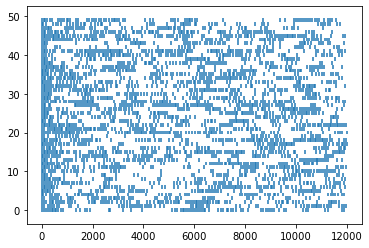

In [2]:
#from models import Model, SynapticConductanceModel
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt


model = SynapticConductanceModel(resistance=Model.LOW, # Model.LOW, Model.HIGH
                                 noise=Model.OFF, n=50, # Model.OFF, Model.LOW, Model,HIGH
                                 offset=SynapticConductanceModel.ACTIVE)


# model = SineModel(resistance=Model.LOW, # Model.LOW, Model.HIGH
#                                   noise=Model.OFF, n=1, # Model.OFF, Model.LOW, Model,HIGH
#                                 )


model.f = 200 * Hz
model.set_stimulus_current(400 * nS) # current should be scaled by 100x for Active Offset so (500nS is actually 5nS)
model._set_variable("i_injected", 90 * pA)


model.run(12*second)

spike_times = [s/ms for s in model.spike_train.values()]

plt.eventplot(spike_times)


In [3]:
#print(spike_times)

In [4]:
import scipy.io
import numpy as np


file_path = 'data0.mat'
scipy.io.savemat(file_path, {'data0': spike_times[0]})

file_path = 'data1.mat'
scipy.io.savemat(file_path, {'data1': spike_times[1]})

file_path = 'data2.mat'
scipy.io.savemat(file_path, {'data2': spike_times[2]})

file_path = 'data3.mat'
scipy.io.savemat(file_path, {'data3': spike_times[3]})

file_path = 'data4.mat'
scipy.io.savemat(file_path, {'data4': spike_times[4]})

file_path = 'data5.mat'
scipy.io.savemat(file_path, {'data5': spike_times[5]})

file_path = 'data6.mat'
scipy.io.savemat(file_path, {'data6': spike_times[6]})

file_path = 'data7.mat'
scipy.io.savemat(file_path, {'data7': spike_times[7]})

file_path = 'data8.mat'
scipy.io.savemat(file_path, {'data8': spike_times[8]})

file_path = 'data9.mat'
scipy.io.savemat(file_path, {'data9': spike_times[9]})

file_path = 'data10.mat'
scipy.io.savemat(file_path, {'data10': spike_times[10]})

file_path = 'data11.mat'
scipy.io.savemat(file_path, {'data11': spike_times[11]})

file_path = 'data12.mat'
scipy.io.savemat(file_path, {'data12': spike_times[12]})

file_path = 'data13.mat'
scipy.io.savemat(file_path, {'data13': spike_times[13]})

file_path = 'data14.mat'
scipy.io.savemat(file_path, {'data14': spike_times[14]})

file_path = 'data15.mat'
scipy.io.savemat(file_path, {'data15': spike_times[15]})

file_path = 'data16.mat'
scipy.io.savemat(file_path, {'data16': spike_times[16]})

file_path = 'data17.mat'
scipy.io.savemat(file_path, {'data17': spike_times[17]})

file_path = 'data18.mat'
scipy.io.savemat(file_path, {'data18': spike_times[18]})

file_path = 'data19.mat'
scipy.io.savemat(file_path, {'data19': spike_times[19]})

file_path = 'data20.mat'
scipy.io.savemat(file_path, {'data20': spike_times[20]})

file_path = 'data21.mat'
scipy.io.savemat(file_path, {'data21': spike_times[21]})

file_path = 'data22.mat'
scipy.io.savemat(file_path, {'data22': spike_times[22]})

file_path = 'data23.mat'
scipy.io.savemat(file_path, {'data23': spike_times[23]})

file_path = 'data24.mat'
scipy.io.savemat(file_path, {'data24': spike_times[24]})

file_path = 'data25.mat'
scipy.io.savemat(file_path, {'data25': spike_times[25]})

file_path = 'data26.mat'
scipy.io.savemat(file_path, {'data26': spike_times[26]})

file_path = 'data27.mat'
scipy.io.savemat(file_path, {'data27': spike_times[27]})

file_path = 'data28.mat'
scipy.io.savemat(file_path, {'data28': spike_times[28]})

file_path = 'data29.mat'
scipy.io.savemat(file_path, {'data29': spike_times[29]})

file_path = 'data30.mat'
scipy.io.savemat(file_path, {'data30': spike_times[30]})

file_path = 'data31.mat'
scipy.io.savemat(file_path, {'data31': spike_times[31]})

file_path = 'data32.mat'
scipy.io.savemat(file_path, {'data32': spike_times[32]})

file_path = 'data33.mat'
scipy.io.savemat(file_path, {'data33': spike_times[33]})

file_path = 'data34.mat'
scipy.io.savemat(file_path, {'data34': spike_times[34]})

file_path = 'data35.mat'
scipy.io.savemat(file_path, {'data35': spike_times[35]})

file_path = 'data36.mat'
scipy.io.savemat(file_path, {'data36': spike_times[36]})

file_path = 'data37.mat'
scipy.io.savemat(file_path, {'data37': spike_times[37]})

file_path = 'data38.mat'
scipy.io.savemat(file_path, {'data38': spike_times[38]})

file_path = 'data39.mat'
scipy.io.savemat(file_path, {'data39': spike_times[39]})

file_path = 'data40.mat'
scipy.io.savemat(file_path, {'data40': spike_times[40]})

file_path = 'data41.mat'
scipy.io.savemat(file_path, {'data41': spike_times[41]})

file_path = 'data42.mat'
scipy.io.savemat(file_path, {'data42': spike_times[42]})

file_path = 'data43.mat'
scipy.io.savemat(file_path, {'data43': spike_times[43]})

file_path = 'data44.mat'
scipy.io.savemat(file_path, {'data44': spike_times[44]})

file_path = 'data45.mat'
scipy.io.savemat(file_path, {'data45': spike_times[45]})

file_path = 'data46.mat'
scipy.io.savemat(file_path, {'data46': spike_times[46]})

file_path = 'data47.mat'
scipy.io.savemat(file_path, {'data47': spike_times[47]})

file_path = 'data48.mat'
scipy.io.savemat(file_path, {'data48': spike_times[48]})

file_path = 'data49.mat'
scipy.io.savemat(file_path, {'data49': spike_times[49]})



